<a href="https://colab.research.google.com/github/lsteffenel/ED-SNI-IntroDL/blob/main/02_Introduction_a_Keras_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construire un modèle de réseaux de neurones avec Keras

Keras est une bibliothèque "haut niveau" utilisée pour simplifier la description de modèles de réseaux de neurones sur Tensorflow (bibliothèque IA de Google). L'avantage surtout est de pouvoir utiliser des GPU pour accélérer le calcul.

Le travail avec Keras suit un cheminement similaires à celui avec Scikit-Learn, mais il y a quelques différences à retenir.

In [1]:
import tensorflow as tf

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
print (tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


Dans le paragraphe suivant vous avez certainement eu un message d'erreur indiquant que vous n'avez pas des GPU. Dans ce cas, Keras utilisera la CPU de la machine.

## Chargement de données

Tout comme Scikit-Learn, Keras a aussi un ensemble de datasets prêt à utilisation pour des exemples. Dans le cas suivant, nous allons charger le dataset MNIST (écriture à la main) et le séparer en deux groupes : Train et Test. Les données de validation (vérification pendant l'entraînement) seront séparés du groupe Train plus tard.

In [2]:
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Dans ce dataset, nous avons 70000 images. 60000 images sont utilisées pour l'entraînement, et 10000 pour l'ensemble de `test`. On peut visualiser les "dimensions" de chacun des ensembles :
- les ensembles "x" contiennent les données. On trouve respectivement 60000 et 10000 matrices 28x28.
- les ensembles "y" contiennent juste les résultats attendus (appelés "étiquettes" ou "label"). On trouve également 60000 et 10000 lignes. Comme les résultats se trouvent sur une "colonne", on n'a pas besoin d'indiquer la dimension "1" pour celle-ci.


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


On peut également voir le contenu des ensembles. Ici, on affiche `y_train` (l'affichage est tronquée).

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Comme on vient de voir, les données de MNIST se présentent sous la forme d'images 28x28 pixels. Ceux-ci peuvent avoir des valeurs de 0 à 255, correspondant à 256 tons de gris. Les labels (`y_train`, par exemple) correspondent aux caractères représentés : les chiffres 0 à 9.

Le paragraphe suivant définit une fonction permettant de visualiser ce dataset.

In [5]:
import random

def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3),(-1,1,lx,ly) or (-1,3,lx,ly)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns:
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    # Torch Tensor ?
    if y.__class__.__name__      == 'Tensor': y=y.numpy()
    if y_pred.__class__.__name__ == 'Tensor': y_pred=y_pred.detach().numpy()

    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,c) or (c,lx,ly)
        if len(x[i].shape)==3:
            if x[i].__class__.__name__ == 'Tensor':
               (c,lx,ly)=x[i].shape
               if c==1:
                   xx=x[i].permute(1,2,0).numpy().reshape(lx,ly)
               else:
                   xx=x[i].permute(1,2,0).numpy() #---> (lx,ly,n)
            else:
                (lx,ly,c)=x[i].shape
                if c==1:
                    xx=x[i].reshape(lx,ly)
                else:
                    xx=x[i]

        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()

Remarquez le "label" correspondant sous chaque image.

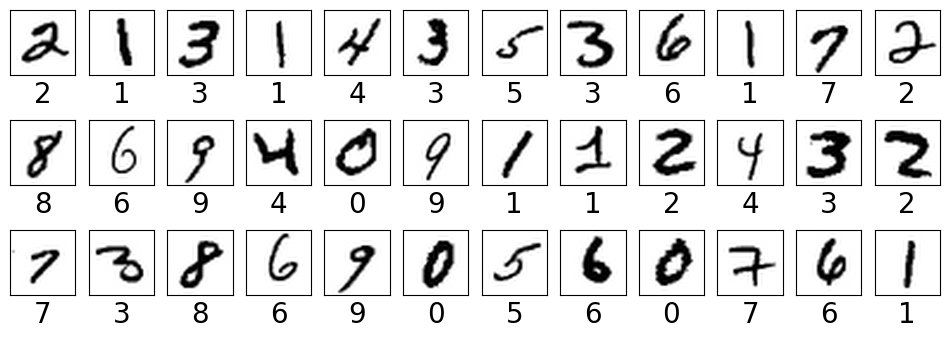

In [6]:
plot_images(x_train, y_train, range(5,41), columns=12)

3


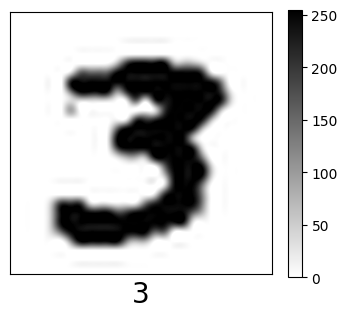

In [7]:
print(y_train[27])
plot_images(x_train, y_train, indices=[27],  x_size=5,y_size=5, colorbar=True)

Les paragraphes suivants font plusieurs opérations afin de préparer les données :

**1 - Transformation et normalisation des données**

Les valeurs de base son des entiers entre 0 et 255 pour représenter les 256 tons de gris. La majorité des algorithmes utilisent des valeurs réels, de préférence dans la fourchette 0 à 1 ou -1 à 1.

Les paragraphes suivantes modifient le type des données (`float32`) puis font une normalisation simple (diviser la valeur par `max`, qui dans ce cas doît être de 255). Bien sûr, d'autres méthodes de normalisation plus élaborées sont possibles, mais ça suffit pour l'instant.

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0.0, max=255.0
After normalization  : Min=0.0, max=1.0


**2 - Transformer les données catégoriques**
Lorsqu'on a des données catégoriques (texte ou numéros), il faut les transformer afin d'éviter des mauvaises compréhensions de la part de l'algorithme (par exemple, supposer que une classe 2 vient toujours après une classe 1). Dans notre cas, nous allons transformer les classes 0 à 9 en représentations numériques (similaire à HotOneEncoder de Sklearn), afin de rendre indépendantes ces classes.

In [10]:
from keras.utils import to_categorical

y_train_hotone = keras.utils.to_categorical(y_train, num_classes=10)
y_test_hotone = keras.utils.to_categorical(y_test, num_classes=10)

In [11]:
y_train_hotone

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## La Création d'un modèle

Keras a plusieurs modes permettant la création de modèles de réseaux de neurones. Dans ce cas, nous allons utiliser l'API `Sequential` qui permet de décrire couche par couche du réseau et les empiler (grâce à `add()`).

Nous allons faire un modèle simple avec des réseaux denses (totalement connectés). La première couche définit la taille de l'entrée (les 784 valeurs reçus du dataset), les autres utilisent par défaut la taille de la sortie de la couche précédente. Egalement, nous indiquons que chaque couche comptera avec 10 neurones.

Finalement, remarquez qu'on utilise deux types de fonction d'activation, sigmoid et softmax.
Pour simplifier la description, sigmoid donne une probabilité entre 0 et 1, alors que Softmax affiche "1" sur la sortie avec la plus grande probabilité et "0" sur les autres. C'est pour cela qu'on utilise Softmax à la sortie, ça permet d'avoir un résultat plutôt qu'une liste de probabilités.

In [12]:
from keras import Sequential
from keras import layers
from keras import optimizers

# Declaration du modèle en Keras
model = keras.Sequential()
model.add(layers.Input((28,28)))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='sigmoid'))
model.add(layers.Dense(20, activation='sigmoid'))
model.add(layers.Dense(10, activation='softmax'))


# résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,380 (95.23 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Une fois défini le modèle, il faut l'entraîner avec les données.
Le paragraphe suivant définit les hyperparamètres du modèle, dont le `batch_size`(taille des sous-ensembles utilisés dans la descente de gradient), le nombre d'epochs (parcours de l'ensemble de données d'entraînement).

L'appel à compile indique aussi qu'on utilise le modèle de descente de gradient SGD (il y a plusieurs), que la métrique utilisée est l'accuracy (métrique qui correspond à (TP+TN)/(TP+TN+FP+FN)), et que la fonction de perte est la `categorical_crossentropy`, une fonction qui compare les probabilités pour des labels catégoriques.

In [13]:
batch_size = 100
#num_classes = 10
epochs= 20

model.compile(loss='categorical_crossentropy',  optimizer='SGD',  metrics=['accuracy'])

Finalement, on lance l'entraînement. Remarquez aussi qu'on n'a pas crée des données Validation avant, on le fera ici en réservant 10% des données de Train (appel à `validation_split=0.1`).

Comme le dataset est simple, on peut faire 50 epoch même sans un GPU.

In [14]:
history = model.fit(x_train, y_train_hotone, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=1 )

#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Je vous invite à lire la documentation : https://keras.io/models/sequential/

Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1130 - loss: 2.3214 - val_accuracy: 0.1792 - val_loss: 2.2696
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2209 - loss: 2.2614 - val_accuracy: 0.2902 - val_loss: 2.2289
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3069 - loss: 2.2195 - val_accuracy: 0.4117 - val_loss: 2.1757
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4047 - loss: 2.1650 - val_accuracy: 0.4378 - val_loss: 2.1030
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4262 - loss: 2.0883 - val_accuracy: 0.4812 - val_loss: 2.0044
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4699 - loss: 1.9858 - val_accuracy: 0.4990 - val_loss: 1.8801
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4860 - loss: 1.8663 - val_accuracy: 0.5260 - val_loss: 1.7398
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5144 - loss: 1.7263 - val_accuracy: 0.

Les paragraphes suivants nous permettent de voir comment le modèle améliore sa performance au fil des epochs

In [15]:
def plot_history(history, figsize=(8,6),
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')

        plt.show()

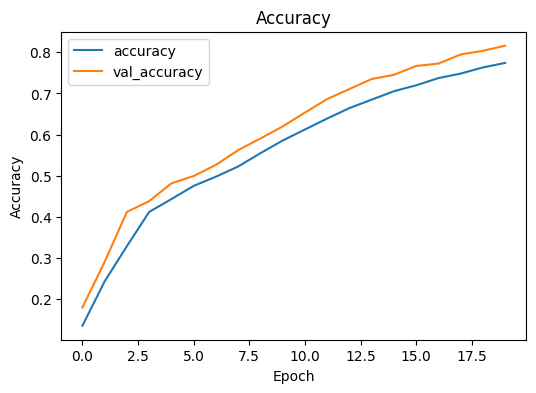

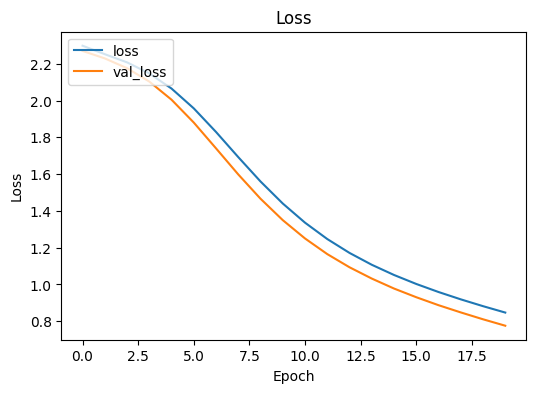

In [16]:
plot_history(history, figsize=(6,4))

Enfin, on peut estimer la performance du modèle avec les données Test.

Comparez ces valeur avec ceux de l'entraînement (`val_loss` et `val_accuracy`
 ci-dessus).

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test_hotone,verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.8154494166374207
Test accuracy: 0.7864000201225281


Ces résultats montrent que le modèle se porte un peu moins bien avec de nouvelles données, mais ça reste intéressant.

# Des erreurs malgré tout

Si vous avez fait attention, on n'a toujours pas touché le dataset x_test/y_test, vu qu'on a fait l'entraînement avec 90% de x_train et validé avec les 10% restants.

On peut donc utiliser x_test comme "nouvelle donnée" et vérifier si notre modèle rend bien les réponses.

Dans le prochain paragraphe nous allons donc produire une estimation y_pred à partir de x_test. Comme la sortie du modèle est un array de 10 positions (notre y_train_hotone), on passe ce résultat à np.argmax() pour obtenir juste le numéro de la classe.

In [19]:
# d'abord, on utilise le modèle pour faire une prévision sur l'ensemble de test
# Ça retourne une liste avec 10 colonnes (une par sortie possible).
y_pred_hotone = model.predict(x_test)

# avec la fonction argmax, on ne garde que l'index de la colonne avec la plus grande valeur
y_pred    = np.argmax(y_pred_hotone, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Maintenant, on affiche quelques éléments, avec la valeur prédite et la valeur attendue (entre parenthèses). Vous pouvez vérifier que quelques prédictions sont incorrectes.

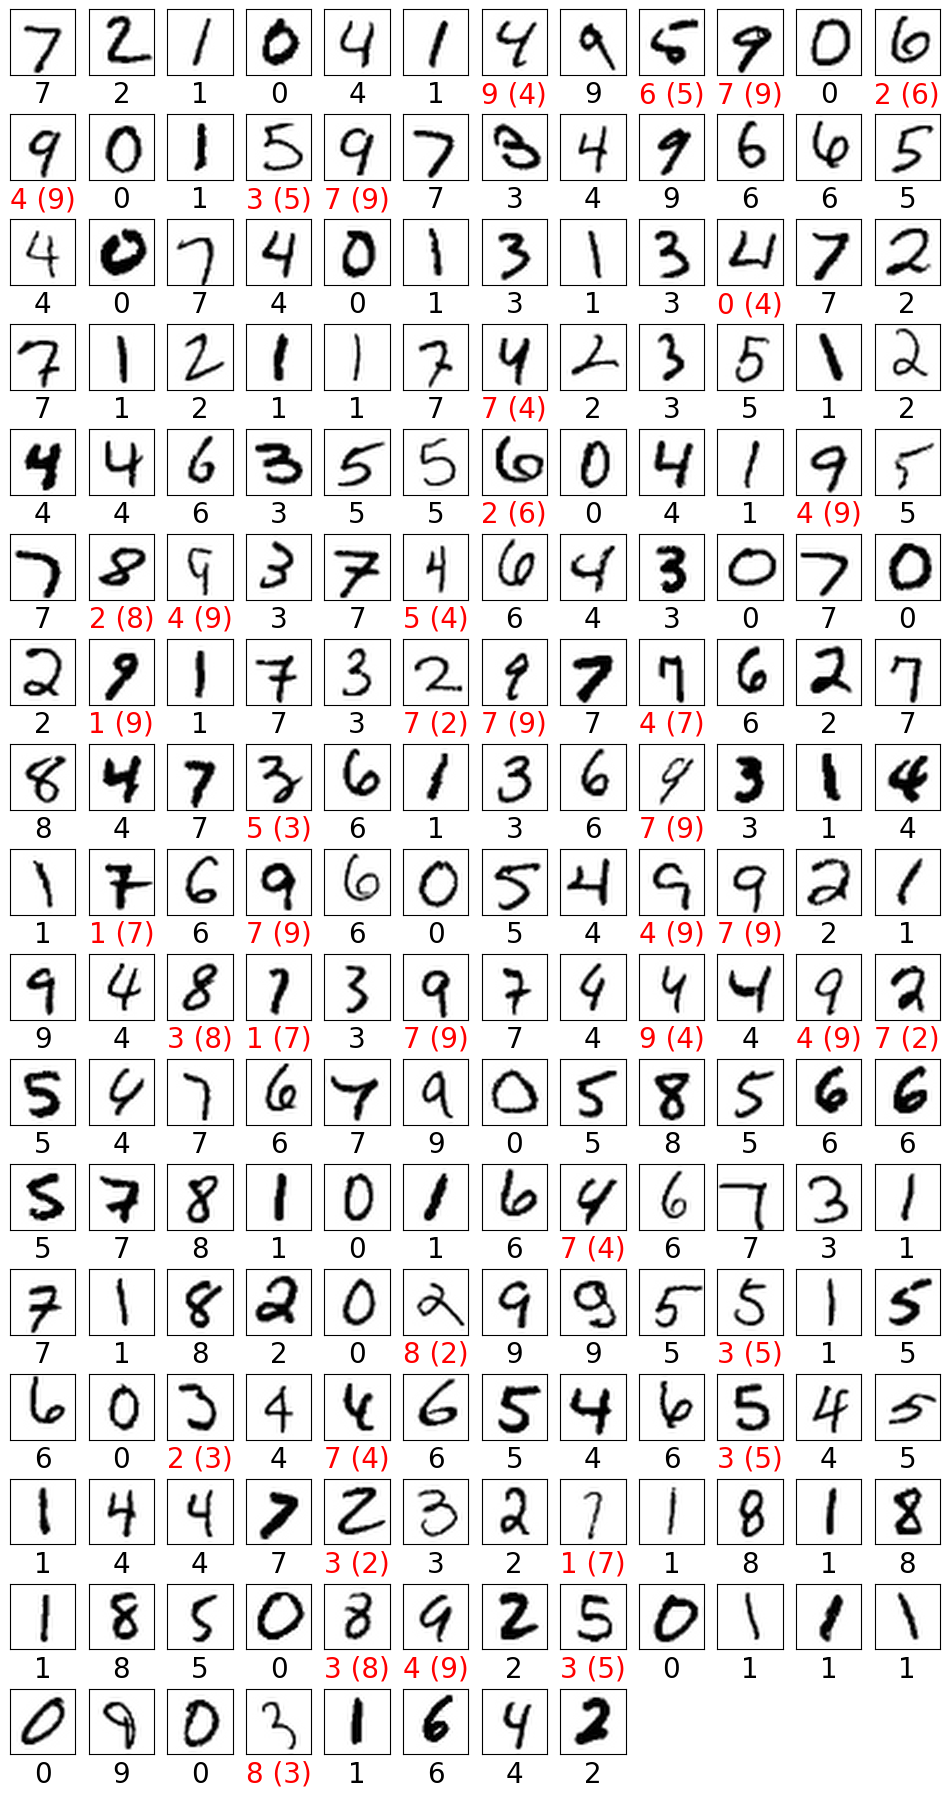

In [20]:
plot_images(x_test, y_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=y_pred)

## Exercice :
On a obtenu avec ce modèle basique, un taux d'accuracy supérieur à 80%.
- Essayer de modifier le nombre de neurones et des couches intermédiaires. Est-ce que ça améliore la précision du modèle ?

